In [1]:
from scipy import optimize
import numpy as np
from matplotlib import pyplot

In [7]:
# encoding: utf-8


import numpy as np
from numpy import linalg as LA


class Fugacidad():

    def __init__(self, eq, w, Tc, Pc, Tr, R, ep, ni, nT, nC, V, T, P, kij, lij):
        self.eq = eq
        self.w = w
        self.Tc = Tc
        self.Pc = Pc
        self.Tr = Tr
        self.R = R
        self.ep = ep
        self.ni = ni
        self.nT = nT
        self.nC = nC
        self.V = V
        self.T = T
        self.P = P
        self.kij = kij
        self.lij = lij
        
        if self.eq == 1:
            # Soave-Redlich-Kwong (SRK)
            self.s1, self.s2 = 1, 2
            self.m = 0.480 + 1.574 * self.w - 0.175 * self.w ** 2
            self.ac = 0.077796070 * self.R ** 2, self.Tc ** 2 / self.Pc
            self.bc = 0.086640 * self.R * self.Tc / self.Pc
        elif self.eq == 2:
            # Peng-Robinson (PR)
            self.s1, self.s2 = 1 + 2 ** 0.5, 1 - (2 ** 0.5)
            self.m = 0.37464 + 1.54226 * self.w - 0.26992 * self.w ** 2
            self.ac = 0.45723553 * self.R ** 2 * self.Tc ** 2 / self.Pc
            self.bc = 0.077796070 * self.R * self.Tc / self.Pc
            #Martín Cismondí
            #self.ac = np.array([2.4959, 2.4959, 208.4949])
            #self.bc = np.array([0.026802, 0.056313, 0.530667])
            #self.m = np.array([0.392414, 0.603252, 1.716810])
        else:
            print ("Che boludo... Modelo no valido, intentalo de nuevo !!! ")


    def parametros(self):        
        self.alfa = (1 + self.m * (1 - (self.T / self.Tc) ** 0.5)) ** 2
        self.dalfadT = - (self.m / self.T) * (self.T / self.Tc) ** 0.5 * (self.m * (- (self.T / self.Tc) ** 0.5 + 1) + 1)
        ter_1 = 0.5 * self.m ** 2 * (self.T / self.Tc) ** 1.0 / self.T ** 2
        ter_2 = 0.5 * self.m * (self.T / self.Tc) ** 0.5 * (self.m * (- (self.T / self.Tc) ** 0.5 + 1) + 1) / self.T ** 2
        self.d2alfaT2 = ter_1 + ter_2
        self.a_ii = self.ac * self.alfa
        self.b_ii = self.bc
        self.da_iidT = self.ac * self.dalfadT
        d2adT2_puros = self.ac * self.d2alfaT2

        if self.nC > 1:
            self.aij = np.ones((len(self.ni), len(self.ni)))
            self.bij = np.ones((len(self.ni), len(self.ni)))
            self.daijdT = np.ones((len(self.ni), len(self.ni)))

            for j in range(self.nC):
                for i in range(self.nC):
                    self.aij[i, j] = (self.a_ii[i] * self.a_ii[j]) ** 0.5
                    self.bij[i, j] = (self.b_ii[i] + self.b_ii[j]) / 2
                    self.bij[i, j] = self.bij[i, j]
                    self.daijdT[i, j] = (self.da_iidT[i] * self.da_iidT[j]) ** 0.5

            for i in range(self.nC):
                for  j in range(self.nC):
                    if i == j:
                        self.aij[i, j] = self.a_ii[i] * (1 - self.kij[i, j])
                        self.daijdT[i, j] = self.da_iidT[i] * (1 - self.kij[i, j])
                    elif i != j:
                        self.aij[i, j] = self.aij[i, j] * (1 - self.kij[i, j])
                        self.daijdT[i, j] = self.daijdT[i, j] * (1 - self.kij[i, j])

        if self.nC == 1:
            return self.a_ii, self.b_ii, self.da_iidT
        else:
            return self.aij, self.bij, self.daijdT

    def parametro_D(self):
        if self.nC == 1:
            self.D = self.ni ** 2 * self.a_ii
            self.Di = 2 * self.ni * self.a_ii
            self.Dij = np.ones((len(self.ni), len(self.ni)))
            for i in range(self.nC):
                for j in range(self.nC):
                    self.Dij[i, j] = 2 * self.aij[i, j]
        else:
            di = np.ones((len(self.ni), len(self.ni)))
            self.Di = np.ones((len(self.ni)))
            self.D = np.ones((len(self.ni)))
            self.Dij = np.ones((len(self.ni), len(self.ni)))
            for i in range(self.nC):
                for j in range(self.nC):
                    di[i, j] = self.ni[j] * self.aij[i, j]
                    self.Di[i] = 2 * np.sum(di[i, :])
                    self.Dij[i, j] = 2 * self.aij[i, j]
                    
            self.D = 0.5 * np.sum(self.ni * self.Di)
            print("Di = ", self.Di)
            print("Dij = ", self.Dij) 

        return self.D

    def parametro_B(self):
        if self.nC == 1:
            self.B = self.ni * self.b_ii
        else:
            self.aux = np.zeros((len(self.ni)))
            for i in range(self.nC):
                for j in range(self.nC):
                    self.aux[i] = self.aux[i] + self.ni[j] * self.bij[i, j]

            self.B = np.sum(self.ni * self.b_ii)
            
            #self.dBi(i)=(2*aux(i)-Bmix)/totn
            self.Bi = np.ones((len(self.ni)))
            self.Bij = np.ones((len(self.ni), len(self.ni)))
            for i in range(len(self.ni)):
                self.Bi[i] = (2 * self.aux[i] - self.B) / self.nT
                for j in range(len(self.ni)):
                    self.Bij[i, j] = (2 * self.bij[i, j] - self.Bi[i] - self.Bi[j]) / self.nT
                    self.Bij[j, i] = self.Bij[i,j]
                    
                    
            print("Bi = ", self.Bi)
            print("Bij = ", self.Bij) 

        return self.B    


    def presion(self):
        '''
        Con el metodo presion(), se calcula la Presión P(T, V, N) del sistema
        para una temperatura T, cantidad de moles N y un volumen V
        R = Constante universal de los gases
        nT = Número total de moles en el sistema
        Pcal = Presión calculada con la ecuación de estado
        Arv = Primera derivada parcial de la energía de Helmholz con respecto al
        volumen V, a T y N constantes
        '''
        self.gv = self.R * self.B / (self.V * (self.V - self.B))
        self.fv = - 1 / ((self.V + self.s1 * self.B) * (self.V + self.s2 * self.B))
        self.ArV = -self.nT * self.gv * self.T - self.D * self.fv
        self.Pcal = self.nT * self.R * self.T / self.V - self.ArV
        return self.Pcal

    def dP_dV(self):
        self.dPdV = -self.ArV2 - self.R * self.T * self.nT / self.V ** 2
        return self.dPdV

    def Z_factor(self):
        #self.P = P
        self.Z = (self.P * self.V) / (self.nT * self.R * self.T)
        return self.Z

    def P_ideal(self):
        #self.P = P
        self.Pxi = (self.ni * self.P) / self.nT
        return self.Pxi

    def dF_dV(self):
        '''
        Primera derivada de F con respecto al volumen Ecu. (68)
        '''
        self.gv = self.R * self.B / (self.V * (self.V - self.B))
        self.fv = - 1 / ((self.V + self.s1 * self.B) * (self.V + self.s2 * self.B))
        self.ArV = -self.nT * self.gv * self.T - self.D * self.fv
        return self.ArV

    def dF_dVV(self):
        '''
        Segunda derivada de F con respecto al volumen Ecu. (74)
        '''
        self.gv2 = self.R * (1 / self.V ** 2 - 1 / (self.V - self.B) ** 2)
        self.fv2 = (- 1 / (self.V + self.s1 * self.B) ** 2 + 1 / (self.V + self.s2 * self.B) ** 2) / self.B / (self.s1 - self.s2)
        self.ArV2 = - self.nT * self.gv2 * self.T - self.D * self.fv2
        return self.ArV2

    def volumen_1(self):
        '''
        Calculo del volumen V(T,P,n) del fluido a una temperatura T, presión P
        y número de moles totales nT especificados.
        Se utiliza el método de Newton con derivada de la función analitica.
        Pendiente cambiar por una función de Scipy.
        '''
        #self.P = P
        self.V = 1.05 * self.B
        lnP = np.log(self.P)
        print ("P_esp = ", self.P)
        print ("V_ini = ", self.V)
        Pite = self.presion()
        lnPcal = np.log(Pite)
        #h = self.P - Pite
        h = lnP - lnPcal
        errorEq = abs(h)
        print ("ErrorP = ", errorEq)
        i = 0
        s = 1.0

        while errorEq > self.ep:
            self.parametro_D()
            self.parametro_B()
            self.dF_dV()
            self.dF_dVV()
            dPite = self.dP_dV()
            Pite = self.presion()
            lnPcal = np.log(Pite)
            #h = self.P - Pite
            h = lnP - lnPcal
            dh = -dPite
            #print self.nT
            self.V = self.V - s * h / dh
            errorEq = abs(h)
            #print "ErrorP = ", errorEq
            #print "V = ", self.V
            #print "Pite = ", Pite
            i += 1
            if i >= 900:
                pass
                #break
        print ("FV = ", dPite)

        return self.V

    def funcion_energia_F(self):
        self.g = self.R * np.log(1 - self.B / self.V)
        self.bv = self.B / self.V
        self.f = np.log((self.V + self.s1 * self.B) / (self.V + self.s2 * self.B)) / self.B / (self.s1 - self.s2)
        self.Ar = -self.nT * self.g * self.T - self.D * self.f
        #print (("g = ", self.g))
        #print (("f: ", self.f))
        #print (("Ar: ", self.Ar))
        return self.g, self.f, self.Ar, self.bv

    def primeras_derivadas1(self):
        print ("# compo = .......", self.nC)

        if self.nC == 1:
            AUX = self.R * self.T / (self.V - self.B)
            self.fB = -(self.f + self.V * self.fv) / self.B
            self.FFB = self.nT * AUX - self.D * self.fB
            self.FFBV = -self.nT * AUX / (self.V - self.B) + self.D * (2 * self.fv + self.V * self.fv2)/self.B
            self.FFBB = self.nT * AUX / (self.V - self.B) - self.D * (2 * self.f + 4 * self.V * self.fv + self.V ** 2 * self.fv2) / self.B ** 2
            self.Di = 2 * self.nT * self.ac * self.alfa
            self.Bi = self.bc
            self.Arn = -self.g * self.T + self.FFB * self.Bi - self.f * self.Di
            self.ArVn = -self.gv * self.T + self.FFBV * self.Bi - self.fv * self.Di
        #elif nC >= 1:
        else:
            # Derivando la ecuación (64) se obtiene la ecuación eq (106)
            self.Bi = np.ones((len(self.ni)))
            for i in range(self.nC):
                self.Bi[i] = (2 * self.aux[i] - self.B) / self.nT

            AUX = self.R * self.T / (self.V - self.B)
            self.fB = -(self.f + self.V * self.fv) / self.B
            self.FFB = self.nT * AUX - self.D * self.fB
            self.FFBV = -self.nT * AUX / (self.V - self.B) + self.D * (2 * self.fv + self.V * self.fv2)/self.B
            
            
            # 2 derivadas
            
            #FFBB=TOTN*AUX/(V-Bmix)-D*(2*f+4*V*fv+V**2*fv2)/Bmix**2
            self.FFBB = self.nT * AUX / (self.V - self.B) - self.D * (2 * self.f + 4 * self.V * self.fv + self.V ** 2 * self.fv2) / self.B ** 2
            
            self.Arn = -self.g * self.T + self.FFB * self.Bi - self.f * self.Di
            self.ArVn = -self.gv * self.T + self.FFBV * self.Bi - self.fv * self.Di
            
            self.Arni = np.ones((len(self.ni)))
            self.ArVni = np.ones((len(self.ni)))
            self.dPdn = np.ones((len(self.ni)))
            for i in range(len(self.ni)):
                self.Arni[i] = -self.g * self.T + self.FFB * self.Bi[i] - self.f * self.Di[i]
                self.ArVni[i] = -self.gv * self.T + self.FFBV * self.Bi[i] - self.fv * self.Di[i]
                self.dPdn [i] = - (self.R * self.T) / self.V - self.ArVn[i]
            
            #Arn2(i,j)=AUX*(dBi(i)+dBi(j))
            #-fB*(dBi(i)*dDi(j)+dBi(j)*dDi(i))
            #+FFB*dBij(i,j)
            #+FFBB*dBi(i)*dBi(j)
            #-f*dDij(i,j)
            
            self.Arn2 = np.ones((len(self.ni), len(self.ni)))
            for i in range(len(self.ni)):
                for j in range(len(self.ni)):
                    QW1 = - self.fB * (self.Bi[i] * self.Di[j] + self.Bi[j] * self.Di[i])
                    QW2 = self.FFB * self.Bij[i,j]
                    QW3 = self.FFBB * self.Bi[i] * self.Bi[j]
                    QW4 = - self.f * self.Dij[i,j]
                    self.Arn2[i, j] = AUX * (self.Bi[i] + self.Bi[j]) + QW1 + QW2 + QW3 + QW4
            
            print("Arn = ", self.Arn)
            print("Arni = ", self.Arni)
            print("ArVn = ", self.ArVn)            
            print("ArVni = ", self.ArVni)
            print("dPdn = ", self.dPdn)
            
            print("Arn2 = ", self.Arn2)
            
            
            
            

        #print("Bi = ", self.Bi)
        #print ("Di = ", self.Di)
        #print ("fB = ", self.fB)
        #print ("FFB = ", self.FFB)
        #print ("Arn cal = ", self.Arn)

        return self.Arn, self.Arn, self.Arn

    def multicomponente_lv(self, P):
        self.P = P
        Veq = np.array([[1], [1.1]])
        #Fug = np.ones((len(self.ni), len(self.ni)-1))
        Fug = np.ones((2, 3))
        Ki_PTN = np.ones((1, 3))
        print ("Ki_PTN", Ki_PTN)
        i = 0
        #self.V = v[i]
        nTF = [1, 2]
        nF = 2
        niLV = np.array([[0.23, 0.67, 0.10], [0.23, 0.67, 0.10]])
        #ni = np.array([0.23, 0.67, 0.10])
        for j in range(nF):
            for i in range(nC):
                self.nT = nTF[j]
                self.ni = niLV[j]
                #print "nT fase = ", self.nT
                #print "ni fase = ", self.ni
                Veq[j] = self.volumen_1(self.P)
                #print "V fase =", Veq
                self.parametros(self.ni, self.nT, nC, self.V, self.T)
                self.parametro_D()
                self.parametro_B()
                self.funcion_energia_F()
                self.primeras_derivadas()
                Fug[j, :] = self.fugacidad()
                #print "Fug = ", Fug
            print ("fase ..................................................", j)
        print ("FUG líq = ", Fug[0, :])
        print ("FUG vap = ", Fug[1, :])
        Ki_PTN = Fug[0, :] / Fug[1, :]
        print ("Ki (P, T, n) = ", Ki_PTN)

        return Veq, Fug, Ki_PTN

    def coeficientes_fugacidad(self):
        self.Z = self.Z_factor()
        self.lnOi = self.Arn / (self.R * self.T) - np.log(self.Z)
        self.Oi = np.exp(self.lnOi)

        print("lnOi = ", self.lnOi)
        print("Oi = ", self.Oi)

        return self.Oi

    def fugacidad(self):
        self.Z = self.Z_factor()
        self.Pxi = self.P_ideal()

        ARN_1 = 31.0357268368683
        ARN_2 = -6.35637488487487
        ARN_3 = -95.8172808890964

        #self.Arn[0] = ARN_1
        #self.Arn[1] = ARN_2
        #self.Arn[2] = ARN_3

        self.lnFi = self.Arn / (self.R * self.T) - np.log(self.Z) + np.log(self.Pxi)
        self.Fi = np.exp(self.lnFi)
        self.PHILOG = self.Arn / (self.R * self.T) - np.log(self.Z)
        self.PHILOG_i = self.Arn - np.log(self.Z)
        self.FUGLOG = self.Arn / (self.R * self.T) + np.log(self.ni) + np.log((self.nT * self.R * self.T) / self.V)

        #print ("Z = ", self.Z)
        #print ("Arn = ", self.Arn)
        #print ("Arn/RT = ", self.Arn / (self.R * self.T))
        #print ("ln(ni) = ", np.log(self.ni))
        #print ("ln (nT*R*T/V) = ", np.log((self.nT * self.R * self.T) / self.V))
        print ("lnFi = ", self.lnFi)
        print ("Fi = ", self.Fi)
        #print ("PHILOG = ", self.PHILOG)
        #print ("PHILOG_i = ", self.PHILOG_i)
        print ("FUGLOG = ", self.FUGLOG)

        return self.Fi
    
    def derivarFug(self):
        
        #DO 63 I=1,NC
        #DO 61 K=I,NC
        #FUGN(I,K)=1.D0/TOTN+(Arn2(I,K)+DPDN(I)*DPDN(K)/DPV)/RT
        #FUGN(K,I)=FUGN(I,K)
        
        self.FUGN = np.ones((len(self.ni), len(self.ni)))        
        for i in range(len(self.ni)):
            for j in range(len(self.ni)):
                self.FUGN[i, j] = 1.0 / self.nT + self.Arn2[i, j] + (self.dPdn[i] * self.dPdn[j]) / (self.dPdV * self.R * self.T)
                self.FUGN[j, i] = self.FUGN[i, j]
                
        print("FUGN = ", self.FUGN)
                
        return self.FUGN
                
                
            
            

        
        

    def exp_sol(self):
        '''
        Este método calcula el factor de corrección de la fugacidad del
        componente fluido para determinar la fugacidad del mismo componente
        en estado sólido.
        Fugacidad del sólido puro
        fi_s(T, P) = fi_l(T, P) * EXP(T, P)
        '''
        Tfus = 323.75
        # Temperatura de fusion de n-tetracosane
        # Unidad de Ti_f en Kelvin
        par_sol = np.array([[-176120.0, 8196.20, -55.911, 0.19357, -0.0002235],
                            [-1.66e6, 8.31e3, 0.0, 0.0, 0.0]])
        par_liq = np.array([[423160.0, 1091.9, 0.0, 0.0, 0.0],
                            [7.01e5, 1.47e3, 0.0, 0.0, 0.0]])
        #print ("par_sol", par_sol)
        #print ("par_liq", par_liq)
        # Las unidades de Cp están en J/Kmol.K
        Cp_solido = par_sol[:, 0] + par_sol[:, 1] * T + par_sol[:, 2] * T ** 2 + par_sol[:, 3] * T ** 3 + par_sol[:, 4] * T ** 4
        #print ("Cp_solido", Cp_solido)
        Cp_liquido= par_liq[:, 0] + par_liq[:, 1] * T + par_liq[:, 2] * T ** 2 + par_liq[:, 3] * T ** 3 + par_liq[:, 4] * T ** 4
        #print ("Cp_liquido", Cp_liquido)
        DeltaCp = (Cp_solido - Cp_liquido) * (1.0 / 1000)
        print ("Delta Cp", DeltaCp)

        #Unidades de Delta H de fusión en Kcal/mol
        DeltaH_f = np.array([13.12, 21.23]) * (1000 / 1.0) * (4.18 / 1.0)
        #print ("Delta H de fusion", DeltaH_f)
        T_f = np.array([323.75, 349.05])
        #print ("Temperaturas de fusion = ", T_f)

        Rp = 8.314
        A = (DeltaH_f / (Rp * Tfus)) * (1 - (Tfus / T))
        B = (DeltaCp / Rp) * (1 - (Tfus / T))
        C = (DeltaCp / Rp) * np.log(Tfus / T)
        self.EXP = np.exp(A - B - C)

        print ("A = ", A)
        print ("B = ", B)
        print ("C = ", C)
        print ("EXP = ", self.EXP)

        return self.EXP
    
    def exp_sol_1(self):
        '''
        Este método calcula el factor de corrección de la fugacidad del
        componente fluido para determinar la fugacidad del mismo componente
        en estado sólido.
        Fugacidad del sólido puro
        fi_s(T, P) = fi_l(T, P) * EXP(T, P)
        '''
        Tpt = 323.75
        Ppt = 1.38507E-8
        R = 8.314472
        AH = 54894000
        AH1 = -0.0376300841
        
        a = ((AH / (R * Tpt)) * (1 - (Tpt / self.T))) / 1000
        b = ((AH1 / (R * self.T)) * (self.P - Ppt)) / 100
        self.EXP_1 = a + b
        
        return self.EXP_1
    
    def exp_sol_3(self):
        '''
        Este método calcula el factor de corrección de la fugacidad del
        componente fluido para determinar la fugacidad del mismo componente
        en estado sólido.
        Fugacidad del sólido puro
        fi_s(T, P) = fi_l(T, P) * EXP(T, P)
        '''
        # [=] K
        # [=] bar
        # [m3 / Kmol]
        # Constante R [=] 0.08314472 bar.l/(mol.K)
        
        Tpt = 323.75
        Ppt = 3.2015002E-8
        Avsl = -0.0565500835
        
        c1 = -14213.5004
        c2 = 605153.4382
        c3 = -591592.556
        
        R = 0.08314472
        
        A1 = c1 * (1 - Tpt / self.T)
        A2 = c2 * (-1 + Tpt / self.T + np.log(self.T / Tpt))
        A3 = c3 * (-1 + self.T / (2 * Tpt) + Tpt / (2 * self.T)) + (Tpt / self.T) * (self.P - Ppt)
        
        FE = (Avsl / (R * self.T)) * (A1 + A2 + A3)
        self.EXP_3 = np.exp(FE)
        #EFE
        
        return self.EXP_3
        

    def fluido(self):
        #self.P = P
        #ab = self.parametros(self.ni, self.nT, self.nC, self.V, self.T)
        ab = self.parametros()        
        #print (("aij = ", ab[0]))
        #print (("bij = ", ab[1]))
        #print ("................................................................")
        D = self.parametro_D()
        B = self.parametro_B()
        #print (("D = ", D))
        #print (("B = ", B))
        #print ("................................................................")
        Vol_1 = self.volumen_1()
        print (("Volumen_1 = ", Vol_1))
        print (("Densidad =", 1 / Vol_1))
        print ("................................................................")
        F = self.funcion_energia_F()
        #print (("g = ", F[0]))
        #print (("f = ", F[1]))
        #print (("F = ", F[2]))
        #print (("bv = ", F[3]))
        #print ("................................................................")
        dF = self.primeras_derivadas1()
        #print (("dFdni = ", dF[0]))
        #print (("dFdT = ", dF[1]))
        #print (("dFdV = ", dF[2]))
        #print ("................................................................")
        Z = self.Z_factor()
        #print ("Z =", Z)
        Zcal = (self.P * Vol_1) / (self.nT * self.R * self.T)
        #print ("Zcal =", Zcal)
        #print ("................................................................")
        Pq = self.presion()
        print (("Pcal =", Pq))
        print ("................................................................")
        self.Fug = self.fugacidad()
        #print (("Fug = ", self.Fug[0]))

        self.CoeFug = self.coeficientes_fugacidad()

        #self.CoeFug = self.Fug / (self.ni * self.P)

        print (("Fug = ", self.Fug))
        print (("CoeFug = ", self.CoeFug))
        print (("lnCoeFug = ", np.log(self.Fug / (self.ni * self.P))))
        print ("................................................................")

        return self.Fug

    def solido(self):
        if self.nC == 1:
            Fug = self.fluido()
            #EXP = self.exp_sol()
            #EXP = self.exp_sol_1()
            EXP = self.exp_sol_3()
            
            print("Exponente = ", EXP)
            FugS = Fug[0] * EXP
            print ("FugS = ", FugS)
        else:
            print ("Aún no se qué hacer para una mezcla de sólidos !!!")
            FugS = 1

        return FugS


    def wilson(self, Pc, Tc, w, T):
        # Ecuación wilson
        lnKi = np.log(Pc / self.P) + 5.373 * (1 + w) * (1 - Tc / self.T)
        self.Ki = np.exp(lnKi)
        return self.Ki

    def beta(self, zi):
        self.zi = zi
        self.Ki = self.wilson(Pc, Tc, w, T)
        Bmin = np.divide((self.Ki * self.zi - 1), (self.Ki - 1))
        #print (("Bmin_inter = ", Bmin))
        Bmax = np.divide((1 - self.zi), (1 - self.Ki))
        #print (("Bmax_inter = ", Bmax))
        self.Bini = (np.max(Bmin) + np.min(Bmax)) / 2
        return self.Bini

    def rice(self, zi, Ki, Bini):
        self.zi = zi
        self.Bini = Bini
        self.Ki = Ki
        self.fg = np.sum(self.zi * (self.Ki - 1) / (1 - self.Bini + self.Bini * self.Ki))
        self.dfg = - np.sum(self.zi * (self.Ki - 1) ** 2 / (1 - self.Bini + self.Bini * self.Ki) ** 2)
        #print g, dg
        return self.fg, self.dfg

    def flash_ideal(self):
        self.Bini = self.beta(zi)
        self.Ki = self.wilson(self.Pc, self.Tc, self.w, self.T)
        print ("Ki_(P, T) = ", self.Ki)
        Eg = self.rice(zi, self.Ki, self.Bini)
        errorEq = abs(Eg[0])
        i, s = 0, 1

        while errorEq > ep:
            Eg = self.rice(zi, self.Ki, self.Bini)
            self.Bini = self.Bini - s * Eg[0] / Eg[1]
            errorEq = abs(Eg[0])
            i += 1
            if i >= 50:
                break

        xy = self.composicion_xy(zi, self.Ki, self.Bini)
        print ("Metano, Butano, Hexano")
        print ("-------------Composición de fase líquida------------------------")
        print ("xi = ", xy[0])
        print ("Sxi = ", np.sum(xy[0]))
        print ("-------------Composición de fase vapor------------------------")
        print ("yi = ", xy[1])
        print ("Syi = ", np.sum(xy[1]))

        return Eg[0], Eg[1], self.Bini

    def flash_PT(self):
        flashID = self.flash_ideal()
        print ("flash (P, T, zi)")
        print ("g, dg, B = ", flashID)
        print ("---------------------------------------------------------------")

        self.Bini = flashID[2]
        print ("Beta_r ini = ", self.Bini)
        moles = self.composicion_xy(zi, self.Ki, self.Bini)

        self.xi, self.yi = moles[0], moles[1]
        nil, niv = moles[2], moles[3]

        fi_F = self.fugac()

        #print "nil = ", nil, np.sum(nil)
        #print "Snil = ", np.sum(nil)
        #print "niv", niv, np.sum(niv)
        #print "Sniv = ", np.sum(niv)

        #nF = 2
        #CoeFugi = np.ones((nF, nC))

        #for i in range(nF):
        #    if i == 1:
        #        self.ni = nil
        #        self.nT = np.sum(self.ni)
        #    elif i == 2:
        #        self.ni = niv
        #        self.nT = np.sum(self.ni)

        #    Flug_i = self.fluido(self.P)
        #    CoeFugi[i, :] = Flug_i[1]

        #print CoeFugi
        #self.Ki = CoeFugi[0, :] / CoeFugi[1, :]

        self.Ki = fi_F[0] / fi_F[1]

        L = 1.0

        self.Ki = self.Ki * L

        Ki_1 = self.Ki
        print ("Ki_(P, T, ni) primera = ", self.Ki)

        print ("----------------------------------------------------------------")

        #self.Ki = np.array([1.729, 0.832, 0.640])

        #self.Ki = self.wilson(self.Pc, self.Tc, self.w, self.T)
        #print "Ki_(P, T) = ", self.Ki

        while 1:
            i, s = 0, 0.1

            while 1:
                Eg = self.rice(zi, self.Ki, self.Bini)
                print (Eg)
                self.Bini = self.Bini - s * Eg[0] / Eg[1]
                print (self.Bini)
                errorEq = abs(Eg[0])
                i += 1
                #print i

                #if self. Bini < 0 or self.Bini > 1:
                    #break
                #    self.Bini = 0.5
                if i >= 50:
                    pass
                    #break
                if errorEq < 1e-5:
                    break

            print ("Resultado Real = ", Eg)
            print (" Beta r = ", self.Bini)

            moles = self.composicion_xy(zi, self.Ki, self.Bini)
            self.xi, self.yi = moles[0], moles[1]

            #xy = self.composicion_xy(zi, self.Ki, self.Bini)

            print ("C1 -i-C4 n-C4")
            print ("-----------Composición de fase líquida----------------------")
            print ("xi = ", moles[0])
            print ("Sxi = ", np.sum(moles[0]))
            print ("-----------Composición de fase vapor------------------------")
            print ("yi = ", moles[1])
            print ("Syi = ", np.sum(moles[1]))

            fi_F = self.fugac()

            self.Ki = fi_F[0] / fi_F[1]
            Ki_2 = self.Ki
            dKi = abs(Ki_1 - Ki_2)
            Ki_1 = Ki_2
            print ("Ki_(P, T, ni) = ", self.Ki)

            fun_Ki = np.sum(dKi)
            print ("fun_Ki = ", fun_Ki)

            if fun_Ki < 1e-5:
                break

        return flashID

    def fugac(self):
        '''
        Esta función que se llama fugacidad, calcula los coeficientes de fugacidad
        con una ecuación de estado para mezclas multicomponente
        T = temperatura en Kelvin
        Y = fracción molar del componente i en la fase de vapor
        X = fracción molar del componente i en la fase líquida
        '''
        self.T
        self.P
        #----------------------------------------------------------------------
        self.Fw = 0.48 + (1.574 * self.w) - (0.176 * self.w ** 2)
        a = ((0.42748 * (self.R * self.Tc) ** 2) / self.Pc) * ((1 + self.Fw * (1 - (self.Tr ** 0.5))) ** 2)
        b = (0.08664 * self.R * self.Tc) / self.Pc
        #----------------------------------------------------------------------
        #print Fw, "Parametro a:", a, b

        #Yf = np.array([Y4,Y5,Y6])
        Yf = self.yi
        Xf = self.xi
        #print Yf, Xf
        #----------------------- Vapor -----------------------------------------
        amv = np.sum(Yf * a ** 0.5) ** 2
        aml = np.sum(Xf * a ** 0.5) ** 2
        #-------------------------------
        #print "amv = ", amv
        #print "aml = ", aml

        bmv = np.sum(Yf * b)
        bml = np.sum(Xf * b)
        #print "bmv = ", bmv
        #print "bml = ", bml

        Av = (amv * self.P) / ((self.R * self.T) ** 2)
        Bv = (bmv * self.P) / (self.R * self.T)
        #-------------------- Liquido -------------------
        Al = (aml * self.P) / ((self.R * self.T) ** 2)
        Bl = (bml * self.P) / (self.R * self.T)
        #print "Av", Av
        #print "Bv", Bv
        #print "Al", Al
        #print "Av", Bl

        Zfv = [1, -1, (Av - Bv - Bv ** 2), (- Av * Bv)]
        ZfvR = np.roots(Zfv)
        Zv = np.max(ZfvR)
        #print "Zv = ", Zv

        Zfl = [1, -1, (Al - Bl - Bl ** 2), (- Al * Bl)]
        ZflR = np.roots(Zfl)
        Zl = np.min(ZflR)
        #print "Zl = ", Zl
        #----------------------------------------------------------------------
        lnfiv = (b / bmv) * (Zv - 1) - np.log(Zv - Bv) + (Av / Bv)  * ((b / bmv) - (2 * ((a / amv) ** 0.5))) * np.log((Zv + Bv) / Zv)
        self.fiv = np.exp(lnfiv)
        print ("fiv = ", self.fiv)
        lnfil = (b / bml) * (Zl - 1) - np.log(Zl - Bl) + (Al / Bl)  * ((b / bml) - (2 * ((a / aml) ** 0.5))) * np.log((Zl + Bl) / Zl)
        self.fil = np.exp(lnfil)
        print ("fil = ", self.fil)

        return self.fil, self.fiv


    def composicion_xy(self, zi, Ki, Bini):
        self.zi = zi
        self.Ki = Ki
        self.Bini = Bini
        self.xi = zi / (1 - self.Bini + self.Bini * self.Ki)
        self.yi = (zi * self.Ki) / (1 - self.Bini + self.Bini * self.Ki)
        self.li = (zi * (1 - self.Bini)) / (1 - self.Bini + self.Bini * self.Ki)
        self.vi = (zi * self.Bini * self.Ki) / (1 - self.Bini + self.Bini * self.Ki)

        return self.xi, self.yi, self.li, self.vi

In [8]:

def fun(x, Pe, nCf):
    #---------------------------------------------------------------------------
    # Temperatura en K
    # Presión en bar
    # Constante R [=] 0.08314472 bar.l/(mol.K)
    
    # selección de la Ecuación de Estado,
    # eq = 1, (SRK)
    # eq = 2, (PR)
    
    # ep = Criterio de convergencia del método def volumen_1(self, P)
    
    T = x 
    print("Temperatura = ", T)
    P = Pe 
    R = 0.08314472
    eq = 2
    ep = 1e-6
    #---------------------------------------------------------------------------
    # metano - C24
    Tcm = np.array([190.564, 804.0])
    Pcm = np.array([45.99, 9.672])
    wm = np.array([0.0115478, 1.07102])
    nC = nCf
    
    if nC == 1:
        print ("...............................................................")
        ni = np.array([1.0])
        print (ni)
        # C24
        kij = 0.0
        lij = 0.0
        #----------------------------------------------------------------------
        #C24
        Tc = Tcm[1]
        Pc = Pcm[1]
        w = wm[1]
        print ("Tc = ", Tc)
        print ("Pc = ", Pc)
        print ("w = ", w)
        
        print ("...............................................................")
    elif nC == 2:
        print ("...............................................................")
        # metano - C24
        ni = np.array([1 - 0.901, 0.901])
        print (ni)
       
        kij = np.array([[0.000000, 0.059600],
                        [0.059600, 0.000000]])

        lij = 0.0132

        Tc = Tcm
        Pc = Pcm
        w = wm
        print ("Tc = ", Tc)
        print ("Pc = ", Pc)
        print ("w = ", w)
        print ("...............................................................")

    #---------------------------------------------------------------------------
    # Tempertura reducidad
    Tr = T / Tc
    # C24 puro
    V = 0.141604834257319
    nT = np.sum(ni)

    print ("...................................................................")
    fugacidad = Fugacidad(eq, w, Tc, Pc, Tr, R, ep, ni, nT, nC, V, T, P, kij, lij)
        
    if nC == 1:
        SOL = fugacidad.solido()
        print ("...................................................................")
        print ("FUG_SOLID = ", SOL)
        print ("lnFUG_SOLID = ", np.log(SOL))
        print ("...................................................................")
        
        return SOL
    else:
        flu_1 = fugacidad.fluido()
        fugacidad.derivarFug()
        return flu_1    

fun(345.4, 340.0, 2)

Temperatura =  345.4
...............................................................
[ 0.099  0.901]
Tc =  [ 190.564  804.   ]
Pc =  [ 45.99    9.672]
w =  [ 0.0115478  1.07102  ]
...............................................................
...................................................................
Di =  [  53.88339735  970.14647214]
Dij =  [[    3.72729838    59.39444486]
 [   59.39444486  1070.21800455]]
Bi =  [ 0.02680216  0.53769017]
Bij =  [[  1.73472348e-16   5.55111512e-17]
 [  5.55111512e-17   0.00000000e+00]]
P_esp =  340.0
V_ini =  0.51146786699
ErrorP =  0.00671699417405
Di =  [  53.88339735  970.14647214]
Dij =  [[    3.72729838    59.39444486]
 [   59.39444486  1070.21800455]]
Bi =  [ 0.02680216  0.53769017]
Bij =  [[  1.73472348e-16   5.55111512e-17]
 [  5.55111512e-17   0.00000000e+00]]
Di =  [  53.88339735  970.14647214]
Dij =  [[    3.72729838    59.39444486]
 [   59.39444486  1070.21800455]]
Bi =  [ 0.02680216  0.53769017]
Bij =  [[  1.73472348e-16   5.551

array([  4.32869711e+01,   2.68302286e-04])

In [5]:
# Datos experimentales del equilibrio Sólido-líquido C1-C24

t_exp = [323.65, 326.04, 326.43, 328.12, 329.45, 329.89, 333.43, 335.12, 340.19, 344.58, 346.65, 352.53, 362.45, 362.76, 371.82, 379.74]
temp = np.array(t_exp)

p_exp = [1, 101.0, 136.9, 183.8, 266.2, 266.8, 426.9, 480.3, 718.9, 912.5, 1010.6, 1277.8, 1778.0, 1825.1, 2323.4, 2736.1]
pres= np.array(p_exp)

pos = np.arange(len(pres))
Tcal = np.ones((len(pres)))
Tcal

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.])

In [7]:
def gun(x, Pe, n1, n2):
    
    FugS = fun(x, Pe, n1)
    FugF = fun(x, Pe, n2)
    
    eqSF = np.abs(np.abs(np.log(FugS)) - np.abs(np.log(FugF[1])))
    print ("ln(FugS) = ", np.log(FugS))
    print ("ln(FugF) = ", np.log(FugF[1]))
    print ("ln(FugS) - ln(FugF) = ", eqSF)
    
    return eqSF


from scipy.optimize import fsolve

guess = [346.5] # T [=] K, valor inicial de la temperatura para iterar 
Pe = 136.9 # [=] bar, valor especificado de la presión 
Nnp = 1 # número de componentes, Nnp = 1 para el C24 puro
Nnm = 2 # número de componenestes, Nmn = 2 para la mezcla C1 y C24 

# Temperatura a la que converge 
Tcal = fsolve(gun,guess,args=(Pe, Nnp, Nnm), xtol=1e-4)
print(Tcal, "K")

Temperatura =  [ 346.5]
...............................................................
[ 1.]
Tc =  804.0
Pc =  9.672
w =  1.07102
...............................................................
...................................................................
P_esp =  136.9
V_ini =  [ 0.56457468]
ErrorP =  [ 0.53240363]
FV =  [-29604.47973409]
('Volumen_1 = ', array([ 0.56748314]))
('Densidad =', array([ 1.7621669]))
................................................................
# compo = ....... 1
('Pcal =', array([ 136.90013532]))
................................................................
lnFi =  [-12.00429678]
Fi =  [  6.11786866e-06]
FUGLOG =  [-12.00429678]
lnOi =  [-16.92354751]
Oi =  [  4.46885950e-08]
('Fug = ', array([  6.11786866e-06]))
('CoeFug = ', array([  4.46885950e-08]))
('lnCoeFug = ', array([-16.92354751]))
................................................................
Exponente =  [ 4.86139069]
FugS =  [  2.97413497e-05]
.................................

In [15]:
# Calcula la temperatura del ESL para cada presión (pres) especificada,
# tomando como valor inicial de la temperatura el valor de (temp)


for x, Pes, i in zip(temp, pres, pos):
    print (x, P, i)
    
    guess = x # T [=] K
    Pe = Pes # [=] bar
    Tcal[i] = fsolve(gun,guess,args=(Pe, 1, 2), xtol=1e-4)
    
    
#ErrorT = np.abs(Tcal - temp)
#print (Tcal, temp, ErrorT)
Tcal

323.65 1.0 0
Temperatura =  [ 323.65]
...............................................................
[ 1.]
Tc =  804.0
Pc =  9.672
w =  1.07102
...............................................................
...................................................................
P_esp =  1.0
V_ini =  [ 0.56457468]
ErrorP =  [ 4.80511886]
FV =  [-24989.10780275]
('Volumen_1 = ', array([ 0.56871494]))
('Densidad =', array([ 1.75835016]))
................................................................
# compo = ....... 1
('Pcal =', array([ 1.]))
................................................................
lnFi =  [-17.26124217]
Fi =  [  3.18814286e-08]
FUGLOG =  [-17.26124217]
lnOi =  [-17.26124217]
Oi =  [  3.18814286e-08]
('Fug = ', array([  3.18814286e-08]))
('CoeFug = ', array([  3.18814286e-08]))
('lnCoeFug = ', array([-17.26124217]))
................................................................
Exponente =  [ 0.98873162]
FugS =  [  3.15221765e-08]
..............................

array([ 322.65861561,  324.91946742,  325.73456905,  326.80151121,
        328.68045402,  328.69415114,  332.3526483 ,  333.57248076,
        338.99640222,  343.33723415,  345.50684642,  351.28742799,
        361.49784425,  362.4145721 ,  371.63445321,  378.63493779])

In [18]:
Tres = np.array([ 322.65861561,  324.91946742,  325.73456905,  326.80151121,
        328.68045402,  328.69415114,  332.3526483 ,  333.57248076,
        338.99640222,  343.33723415,  345.50684642,  351.28742799,
        361.49784425,  362.4145721 ,  371.63445321,  378.63493779])

Tcal - temp 

array([-0.99138439, -1.12053258, -0.69543095, -1.31848879, -0.76954598,
       -1.19584886, -1.0773517 , -1.54751924, -1.19359778, -1.24276585,
       -1.14315358, -1.24257201, -0.95215575, -0.3454279 , -0.18554679,
       -1.10506221])

In [20]:
fig= pyplot.scatter(Tres,p_exp)


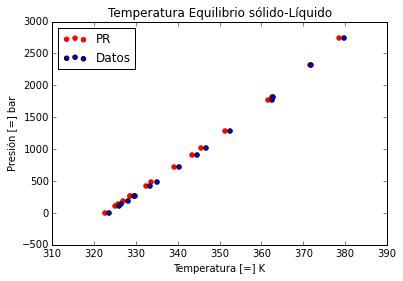

In [45]:
%matplotlib inline

pyplot.scatter(Tres,pres, color = 'red', label = 'PR')
pyplot.scatter(temp,pres, label = 'Datos')
pyplot.title('Temperatura Equilibrio sólido-Líquido')
pyplot.legend(loc="upper left") 
pyplot.xlabel('Temperatura [=] K')  
pyplot.ylabel('Presión [=] bar')


In [ ]:
Kiw = 2.0

Xi = zi * Ki
XT = np.sum(Xi)
xi = Xi / XT

Xi = zi * Ki

di = np.log(zi) + ln.log(zPhi)

Fi = np.log(X) + ln.log(Phi) - di